__Обучите нейронную сеть U-Net на любом датасете. Проведите эксперименты с размером сети , числом ядер, добавьте аугментацию. Соберите результаты в таблицу и сделайте вывод, что влияет на качество сегментации. Что помогло вам улучшить ее точность?__

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
from tensorflow.keras.utils import plot_model
from google.colab import files

In [2]:
uploaded = files.upload()

Saving small_segment.rar to small_segment (1).rar


In [3]:
!pip install rarfile

In [4]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    # print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

In [5]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [6]:
def cuttedUnet(num_classes=14, input_shape=(200, 600, 3), kernel_conv_size=3, add_blocks=False, summary_info=True):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (kernel_conv_size, kernel_conv_size), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (kernel_conv_size, kernel_conv_size), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (kernel_conv_size, kernel_conv_size), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (kernel_conv_size, kernel_conv_size), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    if add_blocks:
        x = MaxPooling2D()(block_4_out)

        # Block 5
        x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv1')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv2')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv3')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        # Load pretrained weights.
        #for_pretrained_weight = MaxPooling2D()(x)
        #vgg16 = Model(img_input, for_pretrained_weight)
        #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

        x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = concatenate([x, block_4_out])
        x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (kernel_conv_size, kernel_conv_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (kernel_conv_size, kernel_conv_size), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary() if summary_info else 0
    return model

In [7]:
import os, fnmatch
imag = os.listdir('/content/images')
imag_label = os.listdir('/content/labels')

PAHT_label = '/content/labels/'
PAHT_image = '/content/images/'

In [8]:
N_EPOCHS = 10
N_BATCH_SIZE = 3
N_WORKERS = 8
SIZE_INPUT = (192, 576, 3)

In [9]:
images = []
segments = []
image_size = SIZE_INPUT[:2]
for i_name in imag:
    images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
    segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

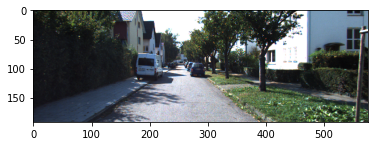

In [10]:
plt.imshow(images[5].convert('RGBA'))
plt.show()

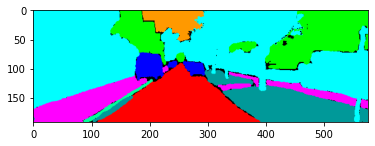

In [11]:
plt.imshow(segments[5].convert('RGBA'))
plt.show()

In [12]:
xTrain_Test = []

for img in images:
    x = image.img_to_array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
print(xTrain_Test.shape)

(17, 192, 576, 3)


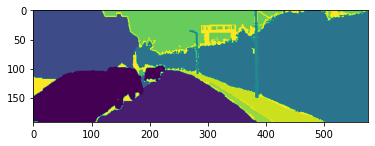

In [13]:
def Color2index(y):
    arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show() 

In [14]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)
print(yTrain_Test.shape)

(17, 192, 576, 14)


In [15]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [16]:
def get_history_plot(history, title=""):
    plt.plot(history.history['val_dice_coef'],label = 'test')
    plt.plot(history.history['dice_coef'],label='train')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.title(title)
    plt.show()

In [17]:
modelC = cuttedUnet(14, SIZE_INPUT, add_blocks=False, summary_info=False)

# plot_model(modelC, to_file='modelC.png')

In [18]:
history = modelC.fit(xTrain, yTrain, epochs=N_EPOCHS, batch_size=N_BATCH_SIZE, validation_data=(xTrain, yTrain))

Epoch 1/10
5/5 [==============================] - 5s 936ms/step - loss: 2.1811 - dice_coef: 0.2018 - val_loss: 10.9554 - val_dice_coef: 0.2817
Epoch 2/10
5/5 [==============================] - 4s 811ms/step - loss: 1.5121 - dice_coef: 0.3654 - val_loss: 11.5026 - val_dice_coef: 0.2816
Epoch 3/10
5/5 [==============================] - 4s 814ms/step - loss: 1.3998 - dice_coef: 0.3947 - val_loss: 11.4182 - val_dice_coef: 0.2824
Epoch 4/10
5/5 [==============================] - 4s 813ms/step - loss: 1.3152 - dice_coef: 0.3929 - val_loss: 11.1423 - val_dice_coef: 0.2844
Epoch 5/10
5/5 [==============================] - 4s 820ms/step - loss: 1.2352 - dice_coef: 0.4320 - val_loss: 10.5373 - val_dice_coef: 0.2909
Epoch 6/10
5/5 [==============================] - 4s 813ms/step - loss: 1.2702 - dice_coef: 0.4349 - val_loss: 9.3634 - val_dice_coef: 0.2977
Epoch 7/10
5/5 [==============================] - 4s 818ms/step - loss: 1.1716 - dice_coef: 0.4524 - val_loss: 8.5278 - val_dice_coef: 0.3002
E

In [19]:
datagen = image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.,
    zoom_range=0.0,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

Epoch 1/10
5/5 [==============================] - 2s 453ms/step - loss: 2.8452 - dice_coef: 0.0863 - val_loss: 3.8150 - val_dice_coef: 0.0726
Epoch 2/10
5/5 [==============================] - 2s 348ms/step - loss: 2.2598 - dice_coef: 0.1565 - val_loss: 2.8628 - val_dice_coef: 0.0887
Epoch 3/10
5/5 [==============================] - 2s 348ms/step - loss: 2.0068 - dice_coef: 0.2171 - val_loss: 2.6156 - val_dice_coef: 0.1021
Epoch 4/10
5/5 [==============================] - 2s 350ms/step - loss: 1.8584 - dice_coef: 0.2651 - val_loss: 2.4990 - val_dice_coef: 0.1118
Epoch 5/10
5/5 [==============================] - 2s 350ms/step - loss: 1.7778 - dice_coef: 0.2739 - val_loss: 2.4473 - val_dice_coef: 0.1170
Epoch 6/10
5/5 [==============================] - 2s 347ms/step - loss: 1.6356 - dice_coef: 0.3074 - val_loss: 2.4174 - val_dice_coef: 0.1201
Epoch 7/10
5/5 [==============================] - 2s 346ms/step - loss: 1.5391 - dice_coef: 0.3356 - val_loss: 2.3919 - val_dice_coef: 0.1195
Epoch 

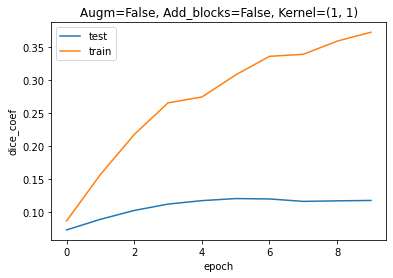

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
5/5 [==============================] - 4s 774ms/step - loss: 2.7048 - dice_coef: 0.0876 - val_loss: 3.0521 - val_dice_coef: 0.2006
Epoch 2/10
5/5 [==============================] - 2s 355ms/step - loss: 2.3804 - dice_coef: 0.1230 - val_loss: 2.8286 - val_dice_coef: 0.1951
Epoch 3/10
5/5 [==============================] - 2s 356ms/step - loss: 2.2010 - dice_coef: 0.1427 - val_loss: 2.6204 - val_dice_coef: 0.1847
Epoch 4/10
5/5 [==============================] - 2s 358ms/step - loss: 2.0872 - dice_coef: 0.1608 - val_loss: 2.4937 - val_dice_coef: 0.1780
Epoch 5/10
5/5 [==============================] - 2s 357ms/step - loss: 2.0076 - dice_coef: 0.1822 - val_loss: 2.4798 - val_dice_coef: 0.1823
Epoch 6/10
5/5 [==============================] - 2s 359ms/step - loss: 1.9009 - dice_coef: 0.2067 - val_loss: 2.3956 - val_dice_coef: 0.1747
Epoch 7/10
5/5 [==============================] - 2s 353ms/step - loss: 

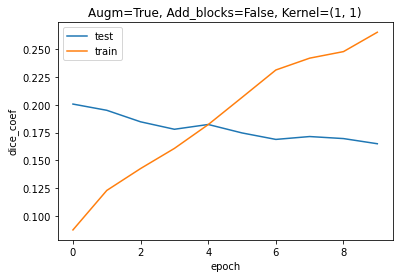

Epoch 1/10
5/5 [==============================] - 3s 525ms/step - loss: 2.6576 - dice_coef: 0.0944 - val_loss: 2.6636 - val_dice_coef: 0.1242
Epoch 2/10
5/5 [==============================] - 2s 390ms/step - loss: 2.1939 - dice_coef: 0.1535 - val_loss: 2.5432 - val_dice_coef: 0.1448
Epoch 3/10
5/5 [==============================] - 2s 387ms/step - loss: 1.9379 - dice_coef: 0.2151 - val_loss: 2.5178 - val_dice_coef: 0.1563
Epoch 4/10
5/5 [==============================] - 2s 388ms/step - loss: 1.7662 - dice_coef: 0.2692 - val_loss: 2.4759 - val_dice_coef: 0.1531
Epoch 5/10
5/5 [==============================] - 2s 385ms/step - loss: 1.6396 - dice_coef: 0.3113 - val_loss: 2.4360 - val_dice_coef: 0.1460
Epoch 6/10
5/5 [==============================] - 2s 386ms/step - loss: 1.5202 - dice_coef: 0.3412 - val_loss: 2.3976 - val_dice_coef: 0.1400
Epoch 7/10
5/5 [==============================] - 2s 389ms/step - loss: 1.5077 - dice_coef: 0.3543 - val_loss: 2.3606 - val_dice_coef: 0.1379
Epoch 

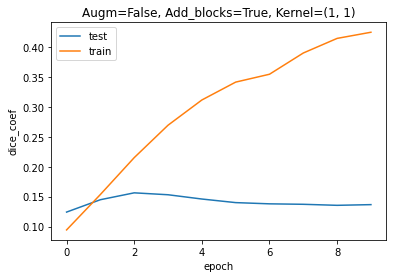

Epoch 1/10
5/5 [==============================] - 3s 572ms/step - loss: 2.8051 - dice_coef: 0.0819 - val_loss: 2.6091 - val_dice_coef: 0.0957
Epoch 2/10
5/5 [==============================] - 2s 396ms/step - loss: 2.4590 - dice_coef: 0.1172 - val_loss: 2.4781 - val_dice_coef: 0.1412
Epoch 3/10
5/5 [==============================] - 2s 393ms/step - loss: 2.2620 - dice_coef: 0.1391 - val_loss: 2.4163 - val_dice_coef: 0.1361
Epoch 4/10
5/5 [==============================] - 2s 397ms/step - loss: 2.1167 - dice_coef: 0.1601 - val_loss: 2.3770 - val_dice_coef: 0.1431
Epoch 5/10
5/5 [==============================] - 2s 394ms/step - loss: 2.0768 - dice_coef: 0.1718 - val_loss: 2.3539 - val_dice_coef: 0.1393
Epoch 6/10
5/5 [==============================] - 2s 394ms/step - loss: 1.9997 - dice_coef: 0.1842 - val_loss: 2.3282 - val_dice_coef: 0.1360
Epoch 7/10
5/5 [==============================] - 2s 393ms/step - loss: 1.9501 - dice_coef: 0.1969 - val_loss: 2.3008 - val_dice_coef: 0.1398
Epoch 

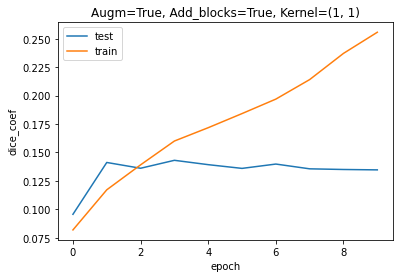

Epoch 1/10
5/5 [==============================] - 4s 843ms/step - loss: 2.2606 - dice_coef: 0.1630 - val_loss: 3.9814 - val_dice_coef: 0.2127
Epoch 2/10
5/5 [==============================] - 4s 743ms/step - loss: 1.6437 - dice_coef: 0.2980 - val_loss: 4.3645 - val_dice_coef: 0.1723
Epoch 3/10
5/5 [==============================] - 4s 746ms/step - loss: 1.4493 - dice_coef: 0.3691 - val_loss: 4.1220 - val_dice_coef: 0.1919
Epoch 4/10
5/5 [==============================] - 4s 747ms/step - loss: 1.3344 - dice_coef: 0.4221 - val_loss: 4.1329 - val_dice_coef: 0.2080
Epoch 5/10
5/5 [==============================] - 4s 747ms/step - loss: 1.2298 - dice_coef: 0.4451 - val_loss: 4.5927 - val_dice_coef: 0.2100
Epoch 6/10
5/5 [==============================] - 4s 744ms/step - loss: 1.1603 - dice_coef: 0.4727 - val_loss: 7.6833 - val_dice_coef: 0.1095
Epoch 7/10
5/5 [==============================] - 4s 747ms/step - loss: 1.1406 - dice_coef: 0.4833 - val_loss: 5.8791 - val_dice_coef: 0.1673
Epoch 

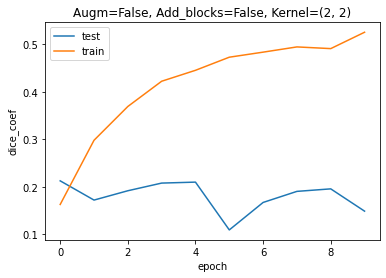

Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 2.7749 - dice_coef: 0.0965 - val_loss: 3.0532 - val_dice_coef: 0.1910
Epoch 2/10
5/5 [==============================] - 4s 750ms/step - loss: 2.1883 - dice_coef: 0.1457 - val_loss: 8.1774 - val_dice_coef: 0.1072
Epoch 3/10
5/5 [==============================] - 4s 751ms/step - loss: 1.9059 - dice_coef: 0.2157 - val_loss: 7.9140 - val_dice_coef: 0.1768
Epoch 4/10
5/5 [==============================] - 4s 758ms/step - loss: 1.6061 - dice_coef: 0.2983 - val_loss: 8.4452 - val_dice_coef: 0.1897
Epoch 5/10
5/5 [==============================] - 4s 755ms/step - loss: 1.6959 - dice_coef: 0.3046 - val_loss: 7.0114 - val_dice_coef: 0.2521
Epoch 6/10
5/5 [==============================] - 4s 754ms/step - loss: 1.5672 - dice_coef: 0.3264 - val_loss: 6.8232 - val_dice_coef: 0.2091
Epoch 7/10
5/5 [==============================] - 4s 752ms/step - loss: 1.5440 - dice_coef: 0.3272 - val_loss: 10.2267 - val_dice_coef: 0.1265
Epoch 8/

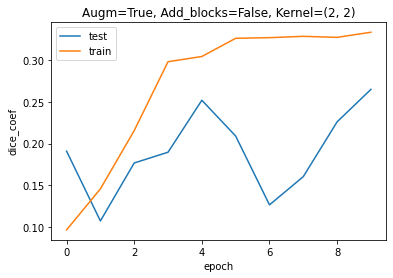

Epoch 1/10
5/5 [==============================] - 5s 986ms/step - loss: 2.4581 - dice_coef: 0.1382 - val_loss: 6.6697 - val_dice_coef: 0.2915
Epoch 2/10
5/5 [==============================] - 4s 852ms/step - loss: 1.7885 - dice_coef: 0.2834 - val_loss: 7.3435 - val_dice_coef: 0.3255
Epoch 3/10
5/5 [==============================] - 4s 850ms/step - loss: 1.5889 - dice_coef: 0.3235 - val_loss: 7.9949 - val_dice_coef: 0.2819
Epoch 4/10
5/5 [==============================] - 4s 850ms/step - loss: 1.4383 - dice_coef: 0.3895 - val_loss: 5.5417 - val_dice_coef: 0.3118
Epoch 5/10
5/5 [==============================] - 4s 848ms/step - loss: 1.2674 - dice_coef: 0.4328 - val_loss: 6.0366 - val_dice_coef: 0.2767
Epoch 6/10
5/5 [==============================] - 4s 851ms/step - loss: 1.2003 - dice_coef: 0.4657 - val_loss: 7.5554 - val_dice_coef: 0.2502
Epoch 7/10
5/5 [==============================] - 4s 854ms/step - loss: 1.0793 - dice_coef: 0.4931 - val_loss: 6.5186 - val_dice_coef: 0.2705
Epoch 

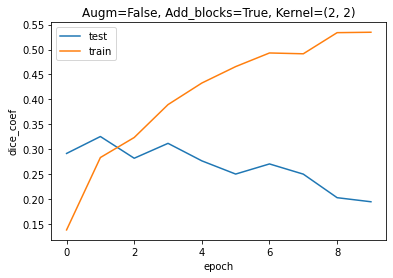

Epoch 1/10
5/5 [==============================] - 5s 1s/step - loss: 2.5561 - dice_coef: 0.1067 - val_loss: 3.7830 - val_dice_coef: 0.1434
Epoch 2/10
5/5 [==============================] - 4s 854ms/step - loss: 2.0093 - dice_coef: 0.2078 - val_loss: 4.5616 - val_dice_coef: 0.2359
Epoch 3/10
5/5 [==============================] - 4s 862ms/step - loss: 1.7173 - dice_coef: 0.2663 - val_loss: 8.0577 - val_dice_coef: 0.2295
Epoch 4/10
5/5 [==============================] - 4s 857ms/step - loss: 1.6868 - dice_coef: 0.2821 - val_loss: 8.7582 - val_dice_coef: 0.2302
Epoch 5/10
5/5 [==============================] - 4s 859ms/step - loss: 1.5098 - dice_coef: 0.3225 - val_loss: 7.9854 - val_dice_coef: 0.2295
Epoch 6/10
5/5 [==============================] - 4s 858ms/step - loss: 1.4210 - dice_coef: 0.3601 - val_loss: 8.4652 - val_dice_coef: 0.1447
Epoch 7/10
5/5 [==============================] - 4s 865ms/step - loss: 1.3792 - dice_coef: 0.3744 - val_loss: 10.2645 - val_dice_coef: 0.1151
Epoch 8/

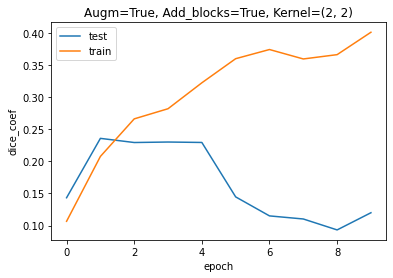

Epoch 1/10
5/5 [==============================] - 5s 941ms/step - loss: 2.3336 - dice_coef: 0.1569 - val_loss: 10.4040 - val_dice_coef: 0.2489
Epoch 2/10
5/5 [==============================] - 4s 825ms/step - loss: 1.5449 - dice_coef: 0.3552 - val_loss: 11.8887 - val_dice_coef: 0.2618
Epoch 3/10
5/5 [==============================] - 4s 821ms/step - loss: 1.4102 - dice_coef: 0.3778 - val_loss: 11.8446 - val_dice_coef: 0.2620
Epoch 4/10
5/5 [==============================] - 4s 826ms/step - loss: 1.3644 - dice_coef: 0.4052 - val_loss: 11.8309 - val_dice_coef: 0.2621
Epoch 5/10
5/5 [==============================] - 4s 828ms/step - loss: 1.3524 - dice_coef: 0.3797 - val_loss: 11.8138 - val_dice_coef: 0.2619
Epoch 6/10
5/5 [==============================] - 4s 826ms/step - loss: 1.2498 - dice_coef: 0.4362 - val_loss: 11.7558 - val_dice_coef: 0.2608
Epoch 7/10
5/5 [==============================] - 4s 827ms/step - loss: 1.2162 - dice_coef: 0.4477 - val_loss: 11.7030 - val_dice_coef: 0.2607

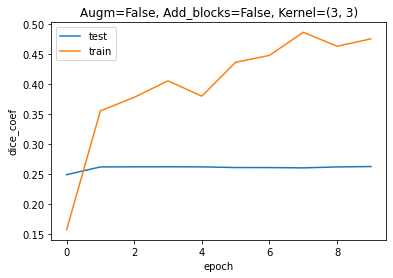

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 2.4872 - dice_coef: 0.1250 - val_loss: 6.4416 - val_dice_coef: 0.3010
Epoch 2/10
5/5 [==============================] - 4s 740ms/step - loss: 1.8577 - dice_coef: 0.2431 - val_loss: 8.0738 - val_dice_coef: 0.2943
Epoch 3/10
5/5 [==============================] - 4s 741ms/step - loss: 1.8116 - dice_coef: 0.2625 - val_loss: 11.4508 - val_dice_coef: 0.2792
Epoch 4/10
5/5 [==============================] - 4s 743ms/step - loss: 1.7421 - dice_coef: 0.2840 - val_loss: 11.0884 - val_dice_coef: 0.2799
Epoch 5/10
5/5 [==============================] - 4s 744ms/step - loss: 1.7242 - dice_coef: 0.2958 - val_loss: 13.0340 - val_dice_coef: 0.1797
Epoch 6/10
5/5 [==============================] - 4s 743ms/step - loss: 1.5326 - dice_coef: 0.3094 - val_loss: 11.5589 - val_dice_coef: 0.2672
Epoch 7/10
5/5 [==============================] - 4s 743ms/step - loss: 1.5439 - dice_coef: 0.3158 - val_loss: 11.4432 - val_dice_coef: 0.2807
Epo

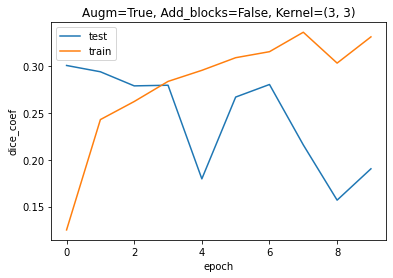

Epoch 1/10
5/5 [==============================] - 6s 1s/step - loss: 2.3377 - dice_coef: 0.1671 - val_loss: 11.8937 - val_dice_coef: 0.2615
Epoch 2/10
5/5 [==============================] - 5s 987ms/step - loss: 1.6494 - dice_coef: 0.3266 - val_loss: 11.8881 - val_dice_coef: 0.2617
Epoch 3/10
5/5 [==============================] - 5s 991ms/step - loss: 1.4983 - dice_coef: 0.3616 - val_loss: 11.9054 - val_dice_coef: 0.2608
Epoch 4/10
5/5 [==============================] - 5s 989ms/step - loss: 1.3936 - dice_coef: 0.3768 - val_loss: 12.1219 - val_dice_coef: 0.2450
Epoch 5/10
5/5 [==============================] - 5s 991ms/step - loss: 1.4053 - dice_coef: 0.3800 - val_loss: 11.8599 - val_dice_coef: 0.2602
Epoch 6/10
5/5 [==============================] - 5s 987ms/step - loss: 1.3079 - dice_coef: 0.3783 - val_loss: 11.8414 - val_dice_coef: 0.2610
Epoch 7/10
5/5 [==============================] - 5s 989ms/step - loss: 1.2321 - dice_coef: 0.4117 - val_loss: 11.6340 - val_dice_coef: 0.2616
Ep

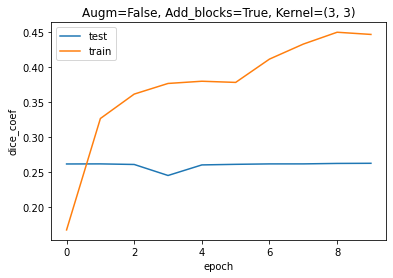

Epoch 1/10
5/5 [==============================] - 6s 1s/step - loss: 2.4194 - dice_coef: 0.1370 - val_loss: 11.7827 - val_dice_coef: 0.2614
Epoch 2/10
5/5 [==============================] - 4s 863ms/step - loss: 1.9656 - dice_coef: 0.2227 - val_loss: 12.7376 - val_dice_coef: 0.2096
Epoch 3/10
5/5 [==============================] - 4s 872ms/step - loss: 1.8106 - dice_coef: 0.2229 - val_loss: 15.3561 - val_dice_coef: 0.0472
Epoch 4/10
5/5 [==============================] - 4s 867ms/step - loss: 1.7170 - dice_coef: 0.2529 - val_loss: 13.4517 - val_dice_coef: 0.1653
Epoch 5/10
5/5 [==============================] - 4s 865ms/step - loss: 1.6525 - dice_coef: 0.2828 - val_loss: 12.0762 - val_dice_coef: 0.2494
Epoch 6/10
5/5 [==============================] - 4s 869ms/step - loss: 1.5057 - dice_coef: 0.3240 - val_loss: 12.5448 - val_dice_coef: 0.2170
Epoch 7/10
5/5 [==============================] - 4s 870ms/step - loss: 1.5365 - dice_coef: 0.3258 - val_loss: 15.4201 - val_dice_coef: 0.0423
Ep

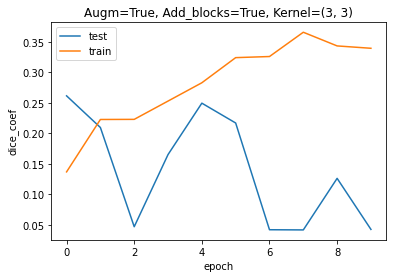

In [20]:
data_plate = {}

for kernel in range(1, 4):
    for add_block in [False, True]:

        modelC = cuttedUnet(14, SIZE_INPUT, kernel_conv_size=kernel, add_blocks=add_block, summary_info=False)
        history = modelC.fit(xTrain, yTrain, epochs=N_EPOCHS, batch_size=N_BATCH_SIZE, validation_data=(xTrain, yTrain))
        title = f"Augm=False, Add_blocks={add_block}, Kernel={(kernel, kernel)}"
        get_history_plot(history, title=title)
        data_plate[title] = history.history['val_dice_coef']

        modelC = cuttedUnet(14, SIZE_INPUT, kernel_conv_size=kernel, add_blocks=add_block, summary_info=False)
        history = modelC.fit_generator(datagen.flow(xTrain, yTrain, batch_size=N_BATCH_SIZE),
                                       epochs=N_EPOCHS,
                                       validation_data=(xTrain, yTrain),
                                       workers=N_WORKERS)
        title = f"Augm=True, Add_blocks={add_block}, Kernel={(kernel, kernel)}"
        get_history_plot(history, title=title)
        data_plate[title] = history.history['val_dice_coef']

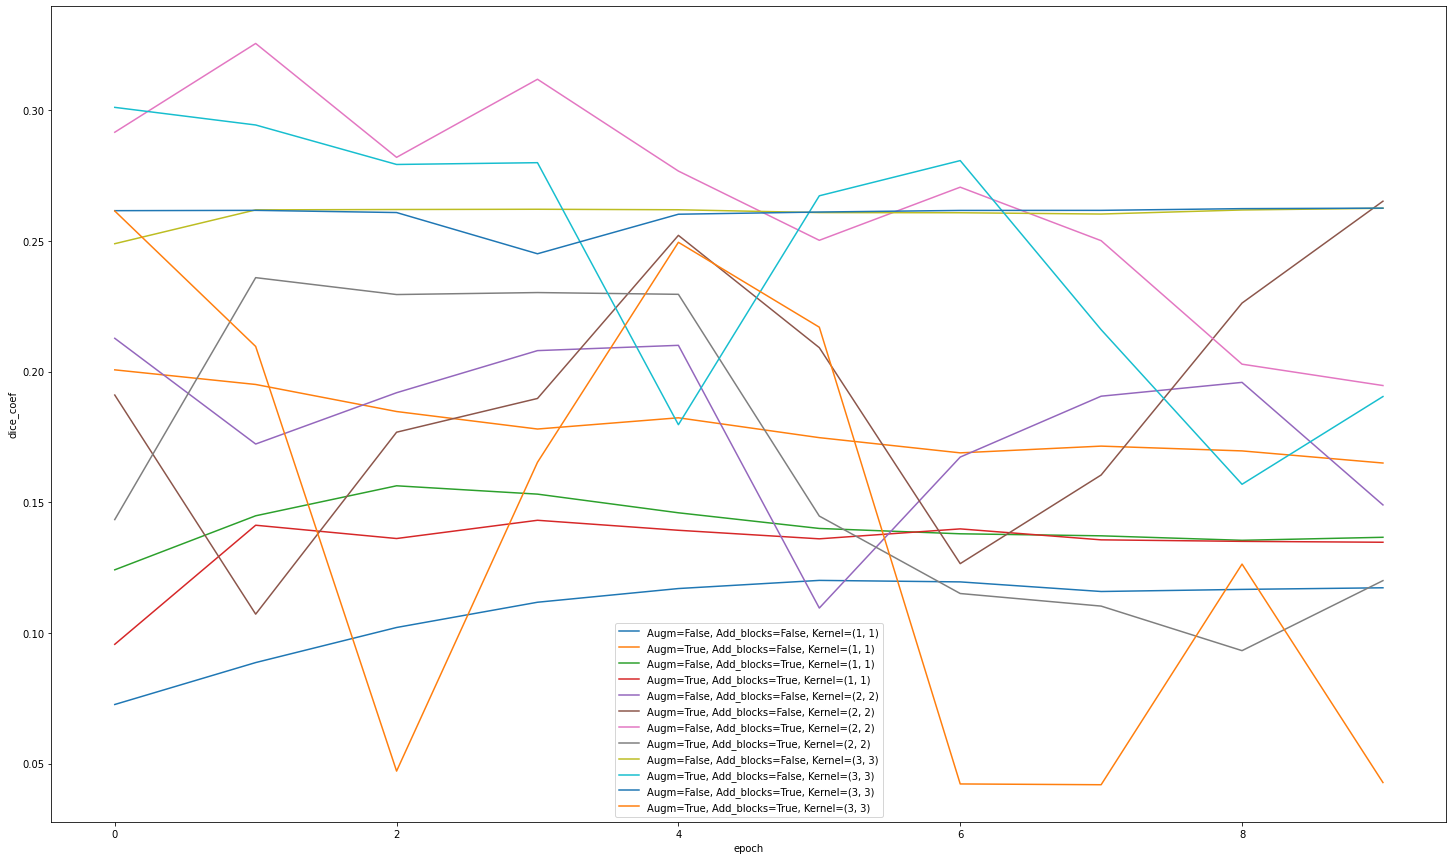

In [21]:
plt.figure(figsize=(25, 15))

for key in data_plate.keys():
    plt.plot(data_plate[key], label=key)

plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend()
plt.show()

__Правильное сочетание глубины сети и размера ядер позволяет улучшить качество сегментации, аугментация помогает улучшить качество при правильных параметрах и ухудшить - при неправильных. Высокое качество показывают как сети, обученные на аугментированных данных, так и обученные только на оригинальных, что, скорее всего, вызвано малым количеством обучающих данных.__